In [1]:
import sys
import os
import glob
import shutil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

sys.path.extend((0, ".."))
import RRE_utils as ut

In [2]:
df0 = pd.read_json("catalog.json")
df0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72145 entries, 0 to 72144
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            72145 non-null  object 
 1   alias           72143 non-null  object 
 2   discoverer      54224 non-null  object 
 3   discoverdate    67623 non-null  object 
 4   maxdate         60150 non-null  object 
 5   maxappmag       60251 non-null  object 
 6   maxabsmag       24333 non-null  object 
 7   host            19998 non-null  object 
 8   ra              68374 non-null  object 
 9   dec             68374 non-null  object 
 10  redshift        29068 non-null  object 
 11  velocity        29059 non-null  object 
 12  lumdist         29053 non-null  object 
 13  claimedtype     57130 non-null  object 
 14  photolink       61950 non-null  object 
 15  references      49781 non-null  object 
 16  ebv             37140 non-null  object 
 17  hostra          14219 non-null 

In [3]:
# Take only relevant columns
# Drop all rows without discovery date
df = df0.take([0, 3, 21], axis=1)
df.dropna(subset=["discoverdate"], inplace=True)

In [4]:
# Calculate number of spectra per SN from spectralink column
bool_spec = ~df["spectralink"].isna()
fn = lambda x: int(x.split(",")[0])
df.loc[bool_spec, "nSpec"] = df.loc[bool_spec, "spectralink"].apply(fn)

In [5]:
# This one SN from 1948 was in MM/DD/YYYY format
df.loc[69714, "discoverdate"] = [{'value': '1948/05/28'}]

# Extract teh discovery dates, and create a column full of datetimes
date = df["discoverdate"].apply(lambda x: str(dict(x[0])["value"]))
date = pd.to_datetime(date, format="%Y/%m/%d", errors="coerce")
df.loc[:, "date"] = date

# There were ~5 SN from ~1000 years ago that did not work with pd.to_datetime.
# Just remove them since they are not helpful for me now.
df = df.dropna(subset=["date"])

In [6]:
# Create year column, the horizontal axis for the plot
df["year"] = df.date.dt.year

# No longer need the discoverdate, spectralink, or date columns
df.drop(columns=["discoverdate", "spectralink", "date"], inplace=True)

# Replace NaNs in the nSpec column with zeros
df = df.fillna({"nSpec": 0}, axis=0)

# Specify dtypes for columns
df = df.astype({"name": str, "nSpec": int, "year": int}, errors="ignore")

In [7]:
# Specify a column specifying if the SN has no spectra
df.loc[df.nSpec == 0, "no spec"] = 1

# Specify a column specifying if the SN has 1 or 2 spectra
df.loc[(df.nSpec == 1) | (df.nSpec == 2), "1 or 2 spec"] = 1

# Specify a column specifying if the SN has 3 or more spectra
df.loc[df.nSpec >= 3, "3plus spec"] = 1

# Fill NaNs in those new columns with 0s
df = df.fillna(0)

# Group the dataframe by year, sum up the occurences in each column for each
# year. This tells us how many SNe had no spectra, 1 or 2 spectra, or 3 or
# more spectra.
plotdf = df.groupby(["year"]).sum().astype(int)
plotdf = plotdf.drop(columns=["nSpec"])

In [8]:
# Grab columns for plotting and rebin them to an evenly spaced array of years
unbinned_years = plotdf.index.values
unbinned_spec0 = plotdf["no spec"].values
unbinned_spec12 = plotdf["1 or 2 spec"].values
unbinned_spec3p = plotdf["3plus spec"].values

years = np.arange(unbinned_years[0], unbinned_years[-1]+1)
rebin_inds = np.digitize(unbinned_years, years) - 1

In [9]:
spec0 = np.zeros_like(years)
spec12 = np.zeros_like(years)
spec3p = np.zeros_like(years)

spec0[rebin_inds] = unbinned_spec0
spec12[rebin_inds] = unbinned_spec12
spec3p[rebin_inds] = unbinned_spec3p

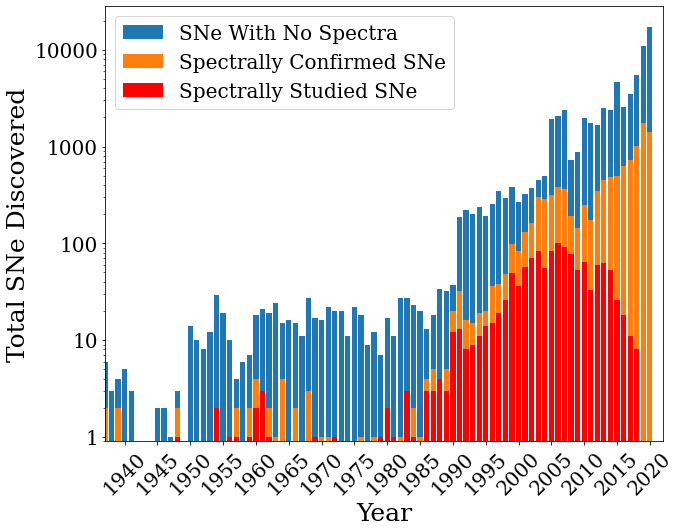

In [10]:
plt.rcParams["font.family"] = "serif"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ax.bar(years, spec0 + spec12 + spec3p, label="SNe With No Spectra")
ax.bar(years, spec12 + spec3p, label="Spectrally Confirmed SNe")
ax.bar(years, spec3p, color="red", label="Spectrally Studied SNe")

ax.set_yscale("log")

ax.set_xlim((1937, 2022))
ax.set_ylim((0.9, None))

ax.set_xticks(
    np.arange(1940, 2020+1, 5),
    np.arange(1940, 2020+1, 5),
    fontsize=20, rotation=45
)
ax.set_yticks(
    [1, 10, 10**2, 10**3, 10**4],
    ["1", "10", "100", "1000", "10000"],
    fontsize=20
)

ax.set_xlabel("Year", fontsize=25)
ax.set_ylabel("Total SNe Discovered", fontsize=25)

ax.legend(loc="upper left", fontsize=20)

fig.savefig("sn_over_time.pdf", bbox_inches="tight", pad_inches=0.1)
fig.show()

In [11]:
df.sort_values("year").head(50)

,name,nSpec,year,no spec,1 or 2 spec,3plus spec
69716,SN1868A,0,1868,1.0,0.0,0.0
69717,SN1885A,0,1885,1.0,0.0,0.0
69718,SN1895A,0,1895,1.0,0.0,0.0
69719,SN1895B,0,1895,1.0,0.0,0.0
69720,SN1901A,0,1901,1.0,0.0,0.0
69721,SN1901B,0,1901,1.0,0.0,0.0
69722,SN1907A,0,1907,1.0,0.0,0.0
69723,SN1909A,0,1909,1.0,0.0,0.0
69724,SN1912A,0,1912,1.0,0.0,0.0
69725,SN1914A,0,1914,1.0,0.0,0.0
